In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr, spearmanr
from scipy.integrate import quad
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
%matplotlib inline

## Preprocessing

In [2]:
pd.set_option('display.max_columns', None)

# COVID-19 testing data
testing = pd.read_csv('https://covidtracking.com/data/download/california-history.csv')
testing.head()

,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-02-15,CA,47043.0,NaN,200,NaN,NaN,NaN,9299.0,0,NaN,2650.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3406365,3406365.0,6487,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,45964127,260910,NaN,NaN,NaN,NaN,NaN,0,45964127,260910
1,2021-02-14,CA,46843.0,NaN,408,NaN,NaN,NaN,9636.0,0,NaN,2733.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3399878,3399878.0,8842,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,45703217,291580,NaN,NaN,NaN,NaN,NaN,0,45703217,291580
2,2021-02-13,CA,46435.0,NaN,433,NaN,NaN,NaN,9998.0,0,NaN,2808.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3391036,3391036.0,9421,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,45411637,286196,NaN,NaN,NaN,NaN,NaN,0,45411637,286196
3,2021-02-12,CA,46002.0,NaN,546,NaN,NaN,NaN,10505.0,0,NaN,2930.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3381615,3381615.0,10059,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,45125441,201460,NaN,NaN,NaN,NaN,NaN,0,45125441,201460
4,2021-02-11,CA,45456.0,NaN,461,NaN,NaN,NaN,11045.0,0,NaN,2996.0,NaN,0,NaN,NaN,NaN,NaN,NaN,3371556,3371556.0,8575,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,44923981,153380,NaN,NaN,NaN,NaN,NaN,0,44923981,153380


In [3]:
# Hospital data by county if needed
hospital_url = 'https://data.ca.gov/dataset/529ac907-6ba1-4cb7-9aae-8966fc96aeef/resource/42d33765-20fd-44b8-a978-b083b7542225/download/hospitals_by_county.csv'
hospital_df = pd.read_csv(hospital_url)

In [4]:
# recovery data?
testing['recovered'].unique()

array([nan])

In [5]:
testing = testing[['date', 'totalTestResults', 'totalTestResultsIncrease']]
testing.rename(columns={'totalTestResults': 'total_tests', 'totalTestResultsIncrease': 'new_tests'}, inplace=True)
testing = testing.sort_values(by='date', ascending=True).reset_index(drop=True)
testing.head()

,date,total_tests,new_tests
0,2020-03-04,515,0
1,2020-03-05,515,0
2,2020-03-06,522,7
3,2020-03-07,531,9
4,2020-03-08,550,19


In [6]:
# NY Times time series
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
nytimes = pd.read_csv(url)
nytimes = nytimes.loc[(nytimes['date'] >= '2020-03-04') &
                      (nytimes['state'] == 'California')].reset_index(drop=True)
nytimes.head()

,date,state,fips,cases,deaths
0,2020-03-04,California,6,55,1
1,2020-03-05,California,6,67,1
2,2020-03-06,California,6,81,1
3,2020-03-07,California,6,100,1
4,2020-03-08,California,6,112,1


In [7]:
# merge testing data and NY Times data
df = pd.merge(testing, nytimes, how='inner', on='date')
df.drop(['state', 'fips'], axis=1, inplace=True)
df.rename(columns={'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True)
df.head()

,date,total_tests,new_tests,total_cases,total_deaths
0,2020-03-04,515,0,55,1
1,2020-03-05,515,0,67,1
2,2020-03-06,522,7,81,1
3,2020-03-07,531,9,100,1
4,2020-03-08,550,19,112,1


In [8]:
# create daily cases and daily deaths columns
df['new_cases'] = df['total_cases'].diff()
df['new_deaths'] = df['total_deaths'].diff()
df.fillna(0, inplace=True)
df['new_cases'] = df['new_cases'].astype('int')
df['new_deaths'] = df['new_deaths'].astype('int')
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths
0,2020-03-04,515,0,55,1,0,0
1,2020-03-05,515,0,67,1,12,0
2,2020-03-06,522,7,81,1,14,0
3,2020-03-07,531,9,100,1,19,0
4,2020-03-08,550,19,112,1,12,0


In [9]:
# add positivity rate column
df['positivity_rate'] = df['total_cases']/df['total_tests']
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


In [10]:
df.to_csv('california_covid19.csv')
print(df.shape)
df.head()

(348, 8)


,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


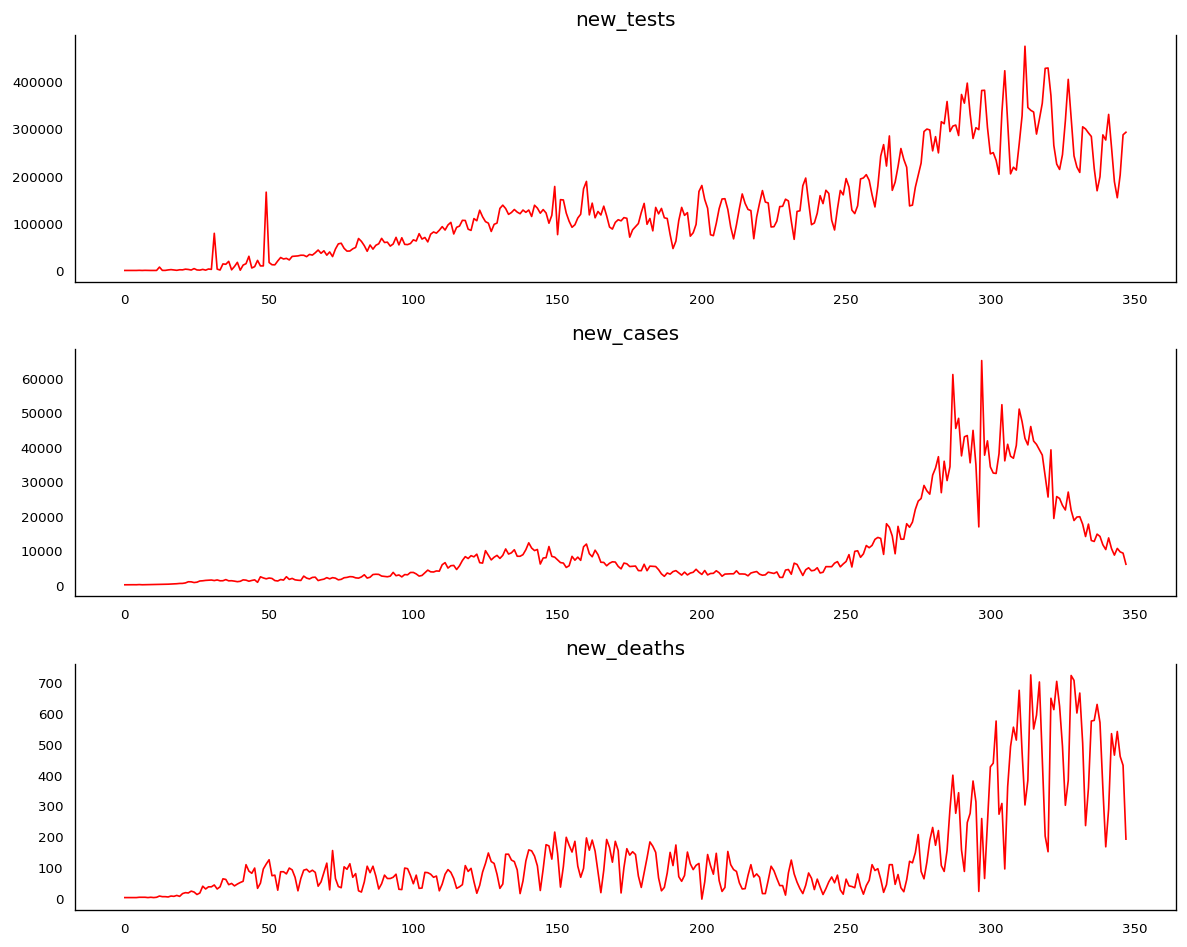

In [11]:
plot_df = df.loc[:, ['new_tests', 'new_cases', 'new_deaths']]
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,8))
plt.rc('font', size=10)
for i, ax in enumerate(axes.flatten()): 
    data = plot_df[plot_df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(plot_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)
plt.tight_layout()

## Correlation

In [12]:
# Our null hypothesis is that the correlation coefficient is not significantly different from 0.
def pearson_corr(column1, column2):
    corr_coef, p_value = pearsonr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)

def spearman_corr(column1, column2):
    corr_coef, p_value = spearmanr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)
    
pearson_corr(df['new_cases'], df['new_deaths'])

correlation: 0.6481985344760536
p value: 7.427020345260099e-43


P-value is less than 0.05, so we can conclude there is a positive correlation between new deaths and new cases.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


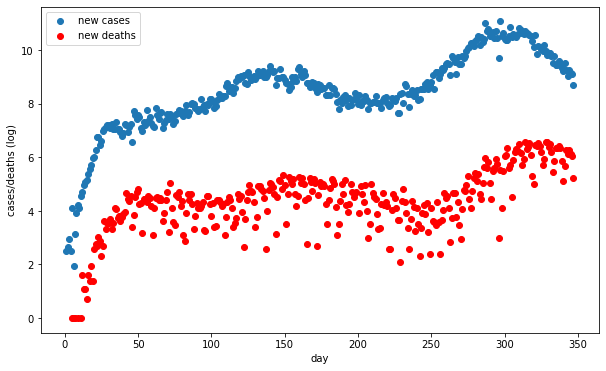

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(np.arange(0, len(df)), np.log(df['new_cases']), label='new cases')
plt.scatter(np.arange(0, len(df)), np.log(df['new_deaths']), label='new deaths', c='red')
plt.legend()
plt.xlabel('day')
plt.ylabel('cases/deaths (log)')
plt.show()

In [14]:
pearson_corr(df['positivity_rate'], df['total_deaths'])

correlation: -0.3151986825229137
p value: 1.82399203500964e-09


In [15]:
df.corr(method='spearman')

,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
total_tests,1.000000,0.920599,1.000000,0.999998,0.839464,0.585993,-0.330523
new_tests,0.920599,1.000000,0.920598,0.920592,0.881967,0.537277,-0.298546
total_cases,1.000000,0.920598,1.000000,0.999998,0.839465,0.585994,-0.330520
total_deaths,0.999998,0.920592,0.999998,1.000000,0.839473,0.586063,-0.330541
new_cases,0.839464,0.881967,0.839465,0.839473,1.000000,0.668078,-0.246078
new_deaths,0.585993,0.537277,0.585994,0.586063,0.668078,1.000000,0.118357
positivity_rate,-0.330523,-0.298546,-0.330520,-0.330541,-0.246078,0.118357,1.000000


## VAR

In [16]:
deaths_df = df[['new_tests', 'total_deaths', 'new_cases', 'new_deaths', 'positivity_rate']]
deaths_df.shape

(348, 5)

In [17]:
log_df = df[['total_cases', 'total_deaths', 'total_tests', 'positivity_rate']]
log_df.head()

,total_cases,total_deaths,total_tests,positivity_rate
0,55,1,515,0.106796
1,67,1,515,0.130097
2,81,1,522,0.155172
3,100,1,531,0.188324
4,112,1,550,0.203636


In [18]:
warnings.filterwarnings('ignore')

# apply log transform
log_df['total_cases'] = np.log(log_df['total_cases'])
log_df['total_deaths'] = np.log(log_df['total_deaths'])
log_df['total_tests'] = np.log(log_df['total_tests'])
log_df.head()

,total_cases,total_deaths,total_tests,positivity_rate
0,4.007333,0.0,6.244167,0.106796
1,4.204693,0.0,6.244167,0.130097
2,4.394449,0.0,6.257668,0.155172
3,4.605170,0.0,6.274762,0.188324
4,4.718499,0.0,6.309918,0.203636


In [19]:
train, test = np.split(log_df, [int(.95 *len(log_df))]) # 95% train data
print(train.shape, test.shape)

(330, 4) (18, 4)


In [20]:
# fit VAR model and forecast
deaths_model = VAR(train)
model_fit = deaths_model.fit()
cols = ['total_cases', 'total_deaths', 'total_tests', 'positivity_rate']
var_pred_df = pd.DataFrame(model_fit.forecast(model_fit.y, steps=len(test)), columns=cols)

# exponentiate data
var_pred_df['total_cases'] = np.exp(var_pred_df['total_cases']).astype('int')
var_pred_df['total_deaths'] = np.exp(var_pred_df['total_deaths']).astype('int')
var_pred_df['total_tests'] = np.exp(var_pred_df['total_tests']).astype('int')
var_pred_df.head()

,total_cases,total_deaths,total_tests,positivity_rate
0,3263005,39364,40711906,0.082540
1,3272758,39868,40537292,0.084686
2,3281351,40407,40605536,0.085746
3,3288376,40959,40833605,0.086045
4,3293582,41506,41164238,0.085817


In [21]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Feb, 2021
Time:                     18:45:55
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -29.6191
Nobs:                     329.000    HQIC:                  -29.7578
Log likelihood:           3062.98    FPE:                1.08739e-13
AIC:                     -29.8498    Det(Omega_mle):     1.02372e-13
--------------------------------------------------------------------
Results for equation total_cases
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.085344         0.036653            2.328           0.020
L1.total_cases             1.021080         0.011772           86.736           0.000
L1.total_deaths           -0.04955

In [22]:
def metrics(test, pred):  
    mae = mean_absolute_error(test, pred)
    rmse = math.sqrt(mean_squared_error(test, pred))
    r2 = r2_score(test, pred)
    print('mae:', mae)
    print('rmse:', rmse)
    print('r2:', r2)

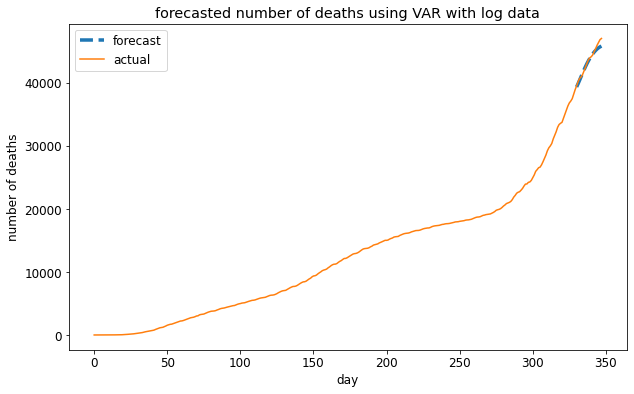

In [23]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(train), len(train)+len(test)), var_pred_df['total_deaths'], 
         '--', label='forecast', linewidth=3.5)
plt.plot(np.arange(0, len(log_df)), deaths_df['total_deaths'], label='actual')
plt.xlabel('day')
plt.ylabel('number of deaths')
plt.title('forecasted number of deaths using VAR with log data')
plt.legend()
plt.show()

In [24]:
# pred_df['total_cases'] = np.exp(np.trapz(pred_df['total_cases']))
# pred_df['total_deaths'] = np.exp(np.trapz(pred_df['total_deaths']))
# pred_df['total_tests'] = np.exp(np.trapz(pred_df['total_tests']))
# pred_df.head(20)

## ARIMA

### Forecast 1 day at a time

In [25]:
x = deaths_df['total_deaths']
size = int(len(x) * 0.8)
train, test = x[0:size], x[size:len(x)]
print(train.shape, test.shape)

(278,) (70,)


https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMA.html

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

order = (3,1,0) sets the lag value to 3 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0

In [26]:
history = [i for i in train]
pred = []
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,0))
    model_fit = model.fit()
    output = model_fit.forecast() # perform 1 step forecast
    yhat = output[0]
    pred.append(yhat)
    obs = np.array(test)[t]
    history.append(obs)

In [27]:
metrics(test, pred)

mae: 123.65877560888008
rmse: 156.24382770743455
r2: 0.9996673979376635


In [28]:
data = {'actual': test, 'prediction': pred, 'diff': abs(test-pred)}
pred_df = pd.DataFrame(data)
pred_df['lower'] = pred_df['prediction'] - 1.96*pred_df['diff']
pred_df['upper'] = pred_df['prediction'] + 1.96*pred_df['diff']
pred_df

,actual,prediction,diff,lower,upper
278,20052,20035.769672,16.230328,20003.958230,20067.581115
279,20238,20178.954326,59.045674,20063.224804,20294.683847
280,20466,20414.268038,51.731962,20312.873394,20515.662683
281,20636,20647.044408,11.044408,20625.397369,20668.691446
282,20854,20772.333721,81.666279,20612.267813,20932.399628
...,...,...,...,...,...
343,45436,45534.235912,98.235912,45341.693524,45726.778300
344,45976,45852.755061,123.244939,45611.194982,46094.315141
345,46435,46411.561026,23.438974,46365.620637,46457.501415
346,46865,46834.255640,30.744360,46773.996693,46894.514586


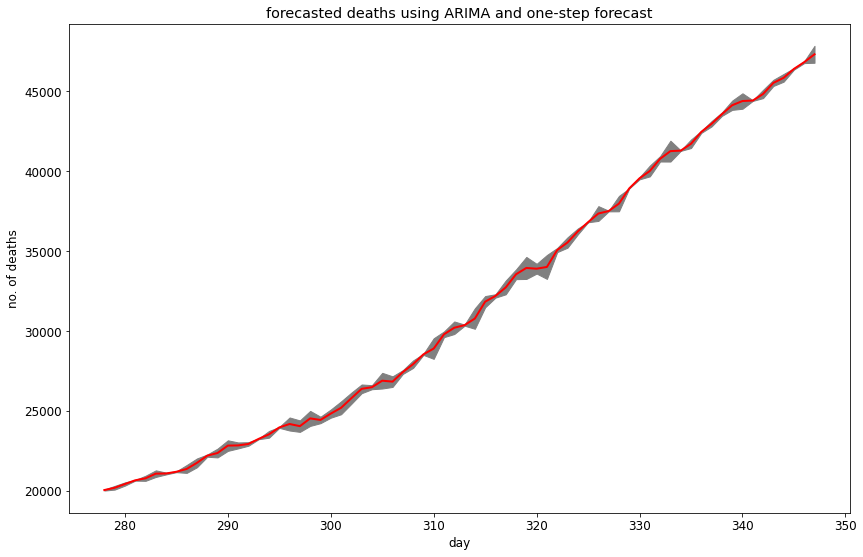

In [29]:
plt.figure(figsize=(14,9))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(train), len(train)+len(pred)), pred, label='forecast', linewidth=2, color='red')
#plt.plot(np.arange(0, len(x)), x, label='actual', linewidth=0.5)
plt.fill_between(np.arange(len(train), len(x)), pred_df['upper'], pred_df['lower'], color='grey', label='error')
plt.xlabel('day')
plt.ylabel('no. of deaths')
#plt.yticks(np.arange(0, max(x), 3000))
plt.title('forecasted deaths using ARIMA and one-step forecast')
plt.show()

### Forecast a certain number of days at once

In [30]:
x = deaths_df['total_deaths']

def split_data(split_size):
    size = int(len(x) * split_size)
    train, test = x[0:size], x[size:len(x)]
    print(train.shape, test.shape)
    return train, test

def arima(train, test):
    model = ARIMA(train, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=len(test))
    return output

def plot_pred(train, output, title):
    plt.figure(figsize=(8,5))
    plt.rcParams.update({'font.size': 12})
    plt.plot(np.arange(len(train), len(train)+len(output)), output, '--', label='forecast', linewidth=3)
    plt.plot(np.arange(0, len(x)), x, label='actual')
    plt.xlabel('day')
    plt.ylabel('number of deaths')
    plt.title(title)
    plt.legend()
    plt.show()

In [31]:
train1, test1 = split_data(0.6)
train2, test2 = split_data(0.7)
train3, test3 = split_data(0.8)
train4, test4 = split_data(0.9)
train5, test5 = split_data(0.95)


arima1 = arima(train1, test1)
arima2 = arima(train2, test2)
arima3 = arima(train3, test3)
arima4 = arima(train4, test4)
arima5 = arima(train5, test5)

(208,) (140,)
(243,) (105,)
(278,) (70,)
(313,) (35,)
(330,) (18,)


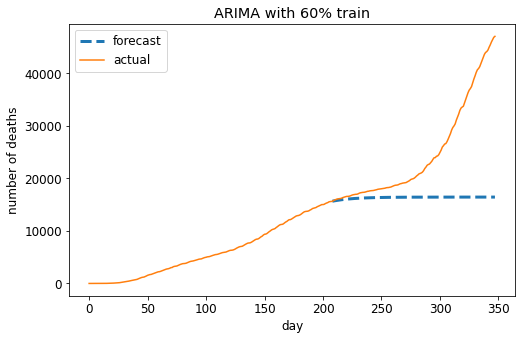

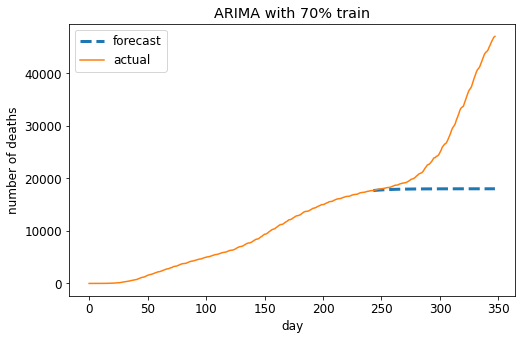

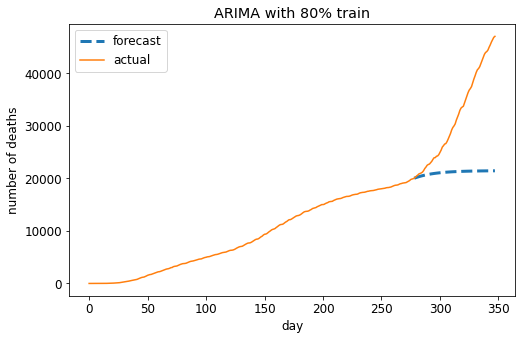

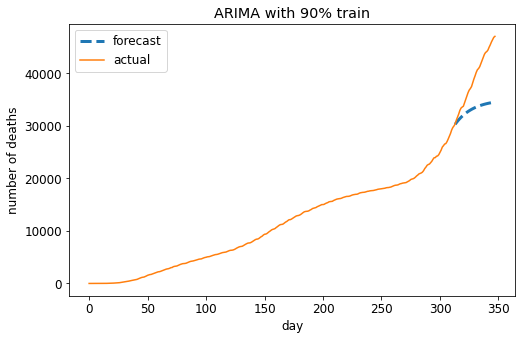

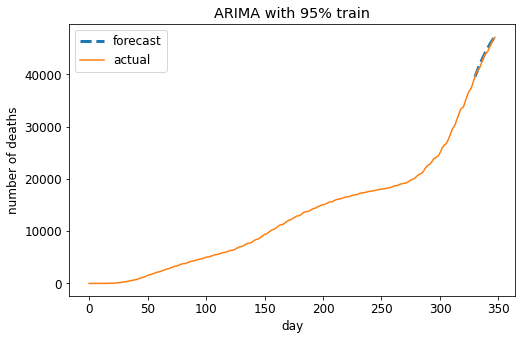

In [32]:
plot_pred(train1, arima1, 'ARIMA with 60% train')
plot_pred(train2, arima2, 'ARIMA with 70% train')
plot_pred(train3, arima3, 'ARIMA with 80% train')
plot_pred(train4, arima4, 'ARIMA with 90% train')
plot_pred(train5, arima5, 'ARIMA with 95% train')

In [33]:
metrics(test5, arima5)

mae: 295.36088447324073
rmse: 351.63111741168314
r2: 0.9768980203550196


In [34]:
arima5_pred = pd.DataFrame(arima5, columns=['prediction'])
arima5_pred['diff'] = abs(test5 - arima5)
arima5_pred['lower'] = arima5_pred['prediction'] - 1.96*arima5_pred['diff']
arima5_pred['upper'] = arima5_pred['prediction'] + 1.96*arima5_pred['diff']
arima5_pred.head()

,prediction,diff,lower,upper
330,39540.540190,13.540190,39514.001418,39567.078963
331,40137.631128,54.368872,40031.068139,40244.194117
332,40723.705371,29.705371,40665.482844,40781.927897
333,41285.332149,357.332149,40584.961137,41985.703161
334,41824.304464,540.304464,40765.307715,42883.301213


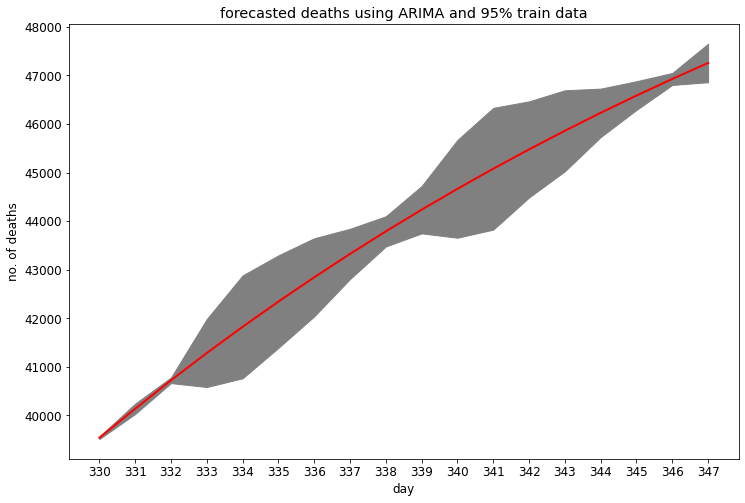

In [35]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(train5), len(train5)+len(arima5)), arima5_pred['prediction'], label='forecast', 
         linewidth=2, color='red')
plt.fill_between(np.arange(len(train5), len(x)), arima5_pred['upper'], arima5_pred['lower'], color='grey')
plt.xlabel('day')
plt.ylabel('no. of deaths')
plt.xticks(np.arange(len(train5), len(train5)+len(arima5), 1))
plt.title('forecasted deaths using ARIMA and 95% train data')
plt.show()

### Forecast the future

In [36]:
# fit model with normal data
model = ARIMA(deaths_df['total_deaths'], order=(4,2,0))
fit = model.fit()
pred = fit.forecast(steps=60)
model_summary = fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           total_deaths   No. Observations:                  348
Model:                 ARIMA(4, 2, 0)   Log Likelihood               -1986.601
Date:                Mon, 15 Feb 2021   AIC                           3983.202
Time:                        18:46:01   BIC                           4002.435
Sample:                             0   HQIC                          3990.861
                                - 348                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2249      0.031     -7.334      0.000      -0.285      -0.165
ar.L2         -0.3092      0.028    -10.967      0.000      -0.364      -0.254
ar.L3         -0.2969      0.029    -10.372      0.000      -0.353      -0.241
ar.L4         -0.2868      0.033     -8.710      0.000      -0.351      -0.222
sigma2      5673.3439    245.278     23.130      0.000    5192.607    6154.080
===================================================================================
Ljung-Box (Q):                      627.47   Jarque-Bera (JB):               410.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              18.02   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- AIC and BIC are used to determine the proper number of parameters. Improve the least squares and log likelihood fit. 
- Minimize AIC and BIC. Try different parameters and make a plot of AIC and BIC.
- Read about AIC and BIC
- Decrease in log likelihood with more parameters
- Compare prediction of ARIMA and VAR

In [37]:
arima_pred = pd.DataFrame(pred, columns=['prediction'])
arima_pred['upper'] = arima_pred['prediction'] + 1.96*arima_pred['diff']
arima_pred['lower'] = arima_pred['prediction'] - 1.96*arima_pred['diff']

KeyError: 'diff'

In [ ]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(train), len(train)+len(pred)), pred, '--', label='forecast', linewidth=3.5)
plt.plot(np.arange(0, len(x)), x, label='actual')
plt.fill_between(np.arange(len(train), len(x)), arima_pred['upper'], arima_pred['lower'], color='grey')
plt.xlabel('day')
plt.ylabel('no. of deaths')
plt.title('forecasted deaths using ARIMA and non-log data')
plt.legend()
plt.show()

In [ ]:
# fit model with log data
log_model = ARIMA(np.log(deaths_df['total_deaths']), order=(3,1,0))
log_fit = log_model.fit()
log_pred = log_fit.forecast(steps=60)
exp_pred = np.exp(log_pred)
log_fit.summary()

In [ ]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(deaths_df), len(deaths_df)+len(exp_pred)), exp_pred, '--', label='forecast')
plt.plot(np.arange(0, len(x)), x, label='actual')
plt.xlabel('day')
plt.ylabel('number of deaths')
plt.title('forecasted number of deaths using ARIMA with log data')
plt.legend()
plt.show()